In [1]:
from mlx_lm import generate, load
from datasets import load_dataset
import pandas as pd

In [3]:
from typing import Dict, List, Optional

from transformers import PreTrainedTokenizer


class Dataset:
    """
    Light-weight wrapper to hold a dataset.
    """

    def __init__(
        self,
        data: List[Dict[str, str]],
        tokenizer: PreTrainedTokenizer,
        text_key: str = "text",
    ):
        self._data = [tokenizer.encode(d[text_key]) for d in data]
        for d in self._data:
            if d[-1] != tokenizer.eos_token_id:
                d.append(tokenizer.eos_token_id)

    def __getitem__(self, idx: int):
        return self._data[idx]

    def __len__(self):
        return len(self._data)


class ChatDataset:
    """
    A dataset for chat data in the format of {"messages": [...]}
    https://platform.openai.com/docs/guides/fine-tuning/example-format
    """

    def __init__(self, data: List[Dict[str, str]], tokenizer: PreTrainedTokenizer):
        self._data = [
            tokenizer.apply_chat_template(
                d["messages"],
                tools=d.get("tools", None),
            )
            for d in data
        ]

    def __getitem__(self, idx: int):
        return self._data[idx]

    def __len__(self):
        return len(self._data)


class CompletionsDataset:
    """
    A dataset for prompt-completion data in the format of {"prompt": ..., "completion": ...}
    or using user-provided keys for prompt and completion values
    https://platform.openai.com/docs/guides/fine-tuning/example-format
    """

    def __init__(
        self,
        data: List[Dict[str, str]],
        tokenizer: PreTrainedTokenizer,
        prompt_key: str,
        completion_key: str,
    ):
        self._data = [
            tokenizer.apply_chat_template(
                [
                    {"role": "user", "content": d[prompt_key]},
                    {"role": "assistant", "content": d[completion_key]},
                ],
            )
            for d in data
        ]

    def __getitem__(self, idx: int):
        return self._data[idx]

    def __len__(self):
        return len(self._data)


def create_dataset(
    data,
    tokenizer: PreTrainedTokenizer,
    prompt_feature: Optional[str] = None,
    completion_feature: Optional[str] = None,
):
    prompt_feature = prompt_feature or "prompt"
    completion_feature = completion_feature or "completion"
    sample = data[0]
    if "messages" in sample:
        return ChatDataset(data, tokenizer)
    elif prompt_feature in sample and completion_feature in sample:
        return CompletionsDataset(data, tokenizer, prompt_feature, completion_feature)
    elif "text" in sample:
        return Dataset(data, tokenizer)
    else:
        raise ValueError(
            "Unsupported data format, check the supported formats here:\n"
            "https://github.com/ml-explore/mlx-examples/blob/main/llms/mlx_lm/LORA.md#data."
        )


def load_hf_dataset(
    data_id: str,
    tokenizer: PreTrainedTokenizer,
    prompt_feature: Optional[str] = None,
    completion_feature: Optional[str] = None,
):
    from datasets import exceptions, load_dataset

    try:
        dataset = load_dataset(data_id)

        names = ("train", "validation", "test")

        train, valid, test = [
            (
                create_dataset(
                    dataset[n], tokenizer, prompt_feature, completion_feature
                )
                if n in dataset.keys()
                else []
            )
            for n in names
        ]

    except exceptions.DatasetNotFoundError:
        raise ValueError(f"Not found Hugging Face dataset: {data_id} .")

    return train, valid, test

In [4]:
model_path = "mlx-community/Mistral-7B-Instruct-v0.3-4bit"
# model_path = "microsoft/Phi-3-mini-4k-instruct"
model, tokenizer = load(model_path)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
prompt = "What is under-fitting and overfitting in machine learning?"

messages = [{"role": "user", "content": prompt}]
prompt = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

response = generate(model, tokenizer, prompt=prompt, verbose=True)

Under-fitting and overfitting are two common problems that can occur when training machine learning models.

1. Under-fitting: This occurs when a model is too simple to learn the underlying pattern in the data. In other words, the model is not complex enough to capture the relationship between the input and output variables. As a result, the model's performance on both the training and test data is poor. This can happen when the model has too few parameters, or when the model is not trained for long enough.

2. Overfitting: This occurs when a model is too complex and starts to fit the noise in the data instead of the underlying pattern. In other words, the model is learning the idiosyncrasies of the training data rather than the general pattern that applies to new, unseen data. As a result, the model performs well on the training data but poorly on the test data. This can happen when the model has too many parameters, or when the model is trained for too long.

The goal in machine lear

In [9]:
print(response)

Under-fitting and overfitting are two common problems that can occur when training machine learning models.

1. Under-fitting: This occurs when a model is too simple to learn the underlying pattern in the data. In other words, the model is not complex enough to capture the relationship between the input and output variables. As a result, the model's performance on both the training and test data is poor. This can happen when the model has too few parameters, or when the model is not trained for long enough.

2. Overfitting: This occurs when a model is too complex and starts to fit the noise in the data instead of the underlying pattern. In other words, the model is learning the idiosyncrasies of the training data rather than the general pattern that applies to new, unseen data. As a result, the model performs well on the training data but poorly on the test data. This can happen when the model has too many parameters, or when the model is trained for too long.

The goal in machine lear

In [10]:
train_set, valid_set, test_set = load_hf_dataset("win-wang/Machine_Learning_QA_Collection", tokenizer)

In [ ]:
# ds = load_dataset("win-wang/Machine_Learning_QA_Collection")
# ds

In [6]:
# splits = {'train': 'train.jsonl', 'validation': 'valid.jsonl', 'test': 'test.jsonl'}
# df = pd.read_json("hf://datasets/win-wang/Machine_Learning_QA_Collection/" + splits["train"], lines=True)

In [ ]:
# train_set = pd.DataFrame(ds["train"])
# dev_set = pd.DataFrame(ds["validation"])
# test_set = pd.DataFrame(ds["test"])
# train_set

MLX requires the data to be placed in a container that allows random access. Here, we convert it into a Python built-in list:

In [7]:
# def preprocess(dataset):
#     return dataset["text"].tolist()

In [8]:
# train_set, dev_set, test_set = map(preprocess, (train_set, dev_set, test_set))

# Model fine-tuning

In [11]:
import matplotlib.pyplot as plt
import mlx.optimizers as optim
from mlx.utils import tree_flatten
from mlx_lm import load, generate
from mlx_lm.tuner import train, TrainingArgs
from mlx_lm.tuner import linear_to_lora_layers
from pathlib import Path
import json

In [12]:
adapter_path = Path("adapters")
adapter_path.mkdir(parents=True, exist_ok=True)

Set the LoRA parameters.

In [13]:
lora_config = {
 "lora_layers": 8,
 "lora_parameters": {
    "rank": 8,
    "scale": 20.0,
    "dropout": 0.0,
}}

In [14]:
with open(adapter_path / "adapter_config.json", "w") as fid:
    json.dump(lora_config, fid, indent=4)

Set the training parameters.

In [15]:
training_args = TrainingArgs(
    adapter_file=adapter_path / "adapters.safetensors",
    iters=50,
    steps_per_eval=10
)

Freeze the base model

In [16]:
model.freeze()

Model(
  (model): LlamaModel(
    (embed_tokens): QuantizedEmbedding(32768, 4096, group_size=64, bits=4)
    (layers.0): TransformerBlock(
      (self_attn): Attention(
        (q_proj): QuantizedLinear(input_dims=4096, output_dims=4096, bias=False, group_size=64, bits=4)
        (k_proj): QuantizedLinear(input_dims=4096, output_dims=1024, bias=False, group_size=64, bits=4)
        (v_proj): QuantizedLinear(input_dims=4096, output_dims=1024, bias=False, group_size=64, bits=4)
        (o_proj): QuantizedLinear(input_dims=4096, output_dims=4096, bias=False, group_size=64, bits=4)
        (rope): RoPE(128, traditional=False)
      )
      (mlp): MLP(
        (gate_proj): QuantizedLinear(input_dims=4096, output_dims=14336, bias=False, group_size=64, bits=4)
        (down_proj): QuantizedLinear(input_dims=14336, output_dims=4096, bias=False, group_size=64, bits=4)
        (up_proj): QuantizedLinear(input_dims=4096, output_dims=14336, bias=False, group_size=64, bits=4)
      )
      (input_l

Convert the linear layers to LoRA layers

In [17]:
linear_to_lora_layers(model, lora_config["lora_layers"], lora_config["lora_parameters"])

Check the trainable model parameters.

In [18]:
num_train_params = (
    sum(v.size for _, v in tree_flatten(model.trainable_parameters()))
)
print(f"Number of trainable parameters: {num_train_params}")

Number of trainable parameters: 3407872


Training mode

In [19]:
model.train()

Model(
  (model): LlamaModel(
    (embed_tokens): QuantizedEmbedding(32768, 4096, group_size=64, bits=4)
    (layers.0): TransformerBlock(
      (self_attn): Attention(
        (q_proj): LoRALinear(
          (linear): QuantizedLinear(input_dims=4096, output_dims=4096, bias=False, group_size=64, bits=4)
          (dropout): Dropout(p=0.0)
        )
        (k_proj): QuantizedLinear(input_dims=4096, output_dims=1024, bias=False, group_size=64, bits=4)
        (v_proj): LoRALinear(
          (linear): QuantizedLinear(input_dims=4096, output_dims=1024, bias=False, group_size=64, bits=4)
          (dropout): Dropout(p=0.0)
        )
        (o_proj): QuantizedLinear(input_dims=4096, output_dims=4096, bias=False, group_size=64, bits=4)
        (rope): RoPE(128, traditional=False)
      )
      (mlp): MLP(
        (gate_proj): QuantizedLinear(input_dims=4096, output_dims=14336, bias=False, group_size=64, bits=4)
        (down_proj): QuantizedLinear(input_dims=14336, output_dims=4096, bias=Fa

In [20]:
opt = optim.Adam(learning_rate=1e-5)

Class to record the data during the training process.

In [21]:
class Metrics:
    train_losses = []
    val_losses = []
    def on_train_loss_report(self, info):
        self.train_losses.append((info["iteration"], info["train_loss"]))
    def on_val_loss_report(self, info):
        self.val_losses.append((info["iteration"], info["val_loss"]))

In [22]:
metrics = Metrics()

Start fine-tuning

In [23]:
train_set, valid_set, test_set = load_hf_dataset("win-wang/Machine_Learning_QA_Collection", tokenizer)

In [24]:
len(valid_set)

1235

In [25]:
train(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    optimizer=opt,
    train_dataset=train_set,
    val_dataset=valid_set,
    training_callback=metrics,
)

Starting training..., iters: 50
Iter 1: Val loss 2.579, Val took 65.140s
Iter 10: Val loss 1.927, Val took 69.441s
Iter 10: Train loss 2.034, Learning Rate 1.000e-05, It/sec 1.643, Tokens/sec 1642.396, Trained Tokens 9996, Peak mem 19.220 GB
Iter 20: Val loss 1.762, Val took 61.352s
Iter 20: Train loss 1.831, Learning Rate 1.000e-05, It/sec 0.412, Tokens/sec 474.226, Trained Tokens 21493, Peak mem 23.328 GB
Iter 30: Val loss 1.797, Val took 89.241s
Iter 30: Train loss 1.789, Learning Rate 1.000e-05, It/sec 0.627, Tokens/sec 850.329, Trained Tokens 35050, Peak mem 27.941 GB
Iter 40: Val loss 1.703, Val took 66.019s
Iter 40: Train loss 1.791, Learning Rate 1.000e-05, It/sec 0.434, Tokens/sec 477.655, Trained Tokens 46065, Peak mem 27.941 GB
Iter 50: Val loss 1.857, Val took 64.510s
Iter 50: Train loss 1.766, Learning Rate 1.000e-05, It/sec 0.784, Tokens/sec 782.464, Trained Tokens 56040, Peak mem 27.941 GB
Saved final weights to adapters/adapters.safetensors.


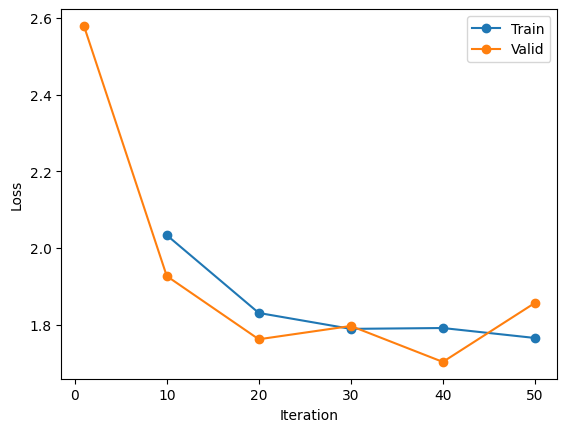

In [26]:
train_its, train_losses = zip(*metrics.train_losses)
val_its, val_losses = zip(*metrics.val_losses)
plt.plot(train_its, train_losses, '-o')
plt.plot(val_its, val_losses, '-o')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(['Train', "Valid"]);

---

In [5]:
model_lora, _ = load(model_path, adapter_path="adapters")

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
model_lora, _ = load(model_path, adapter_path="adapters")

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [12]:
generate(model_lora, tokenizer, prompt=prompt, verbose=True)

Under-fitting and overfitting are two common problems in machine learning.

Under-fitting occurs when a model is too simple and fails to capture the underlying patterns in the data, resulting in poor performance on the training data and poor generalization to new data. This can happen when the model is too simple, the training data is too small, or the model is not flexible enough to capture the complexity of the data.

Overfitting occurs when a model is too complex and fits the training data too closely, resulting in poor performance on new data. This can happen when the model is too complex, the training data is too large, or the model is too flexible. Overfitting can lead to poor generalization, as the model may capture noise and outliers in the training data that are not representative of the underlying patterns in the data.

In both cases, the model may not generalize well to new data, leading to poor performance on the test set. To avoid these problems, it is important to find a 

'Under-fitting and overfitting are two common problems in machine learning.\n\nUnder-fitting occurs when a model is too simple and fails to capture the underlying patterns in the data, resulting in poor performance on the training data and poor generalization to new data. This can happen when the model is too simple, the training data is too small, or the model is not flexible enough to capture the complexity of the data.\n\nOverfitting occurs when a model is too complex and fits the training data too closely, resulting in poor performance on new data. This can happen when the model is too complex, the training data is too large, or the model is too flexible. Overfitting can lead to poor generalization, as the model may capture noise and outliers in the training data that are not representative of the underlying patterns in the data.\n\nIn both cases, the model may not generalize well to new data, leading to poor performance on the test set. To avoid these problems, it is important to 